# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [37]:
from random import random, seed
from itertools import accumulate
import numpy as np
from icecream import ic
from matplotlib import pyplot as plt

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`. 

In [38]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

Generate a boolean 2D array of shape (`NUM_SETS`, `UNIVERSE_SIZE`). Each element will be `True` if the random floating-point number is less than `DENSITY`, `False` otherwise. Guarantee that each element of the universe (each column in `SETS` collection) is included in at least one set (each column in the `SETS` array has at least one `True` value). At the end, calculate the cost for each set in `SETS`, where the cost increases non-linearly with the number of elements in the set.

In [39]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [40]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [41]:
# A dumb solution of "all" sets
dumb_solution = np.full(NUM_SETS, True)
valid(dumb_solution), cost(dumb_solution)

(np.True_, np.float64(4278583.00633686))

## RMHC (Random Mutation Hill Climbing)

Hill climbing algorithm has the tendency to become stuck in suboptimal regions (local optima) since it only accepts improvements. It works fine in convex search spaces. Two functions are implemented.
- `single_mutation`: only one element of the solution array is randomly selected and flipped. Small and localized change in the solution (*exploitation*);
- `multiple_mutation`: several elements of the solution array are mutated simultaneously. More aggressive changes (*exploration*);
- `multiple_mutation_strength`: a different number of elements in the solution array are mutated, depending on the value of `strength` parameter. It is possible to adjust it during the process of optimization (high strength at the start for more exploration, lower strength as the search narrows in on good solutions for fine-tuning). We are using this function in the next example.

In [42]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()
    random_set = rng.integers(0, NUM_SETS)
    new_solution[random_set] = not new_solution[random_set]
    return new_solution

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.01  # Only 1% of the elements in the solution array have a chance of being mutated
    new_solution = np.logical_xor(solution, mask)
    return new_solution

def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    # Ensures that the function always mutates at least one bit
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

def fitness(solution: np.ndarray) -> tuple[bool, float]:
    return (valid(solution), -cost(solution))

Start with a random solution. Greedy solution can lead to a local optima (**basins of attraction**). It is possible not to identify a global optima.

&#9888; This algorithm is not optimal. It does not yield accurate solutions and requires a significant amount of time to complete when large-scale problems are encountered. If you want to deal with large-scale problems, please comment the following section of code and use the *Tabu Search* algorithm provided below.

ic| solution_fitness: (np.True_, np.float64(-4278583.00633686))
ic| fitness(solution): (np.True_, np.float64(-1757717.4538235255))


Text(0, 0.5, 'Fitness')

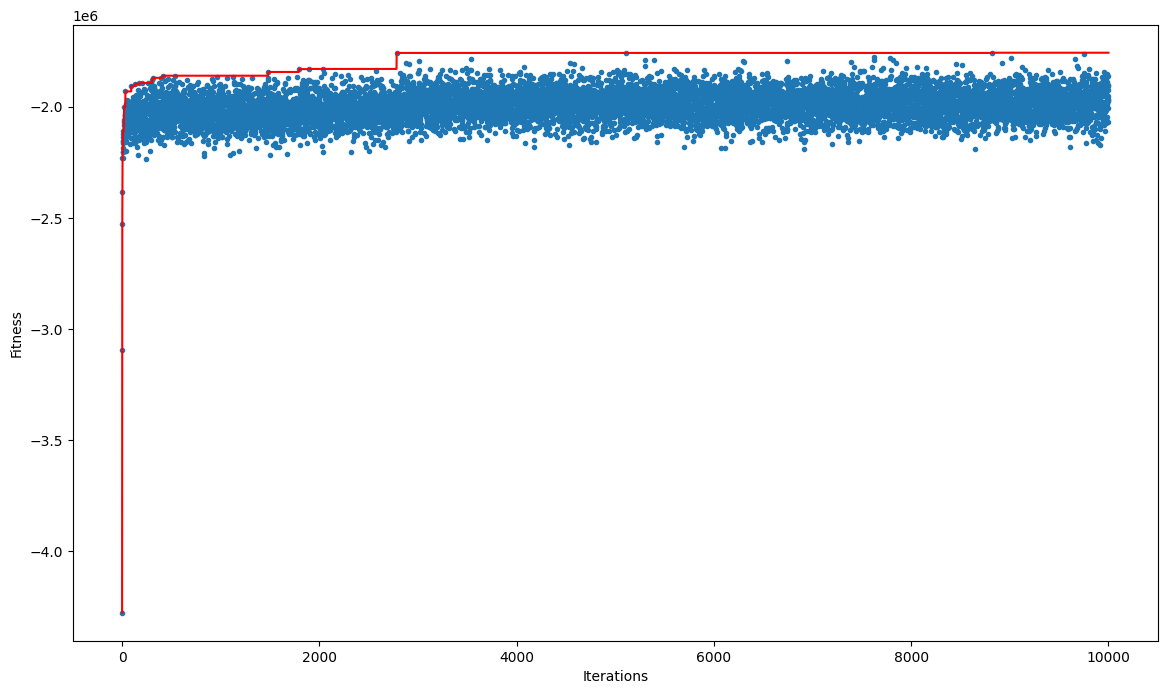

In [43]:
strength = 0.5  # High strength at the beginning of the optimization process

solution = rng.random(NUM_SETS) < 1   # A random solution of all True
solution_fitness = fitness(solution)
ic(solution_fitness)
history = [float(solution_fitness[1])]


for steps in range(10_000):
    if steps % 1000:
        strength /= 2   # decrease strength (mutation rate)
    new_solution = multiple_mutation_strength(solution)
    history.append(float(fitness(new_solution)[1]))
    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(range(len(history)), list(accumulate(history, max)), color = "red")
_ = plt.scatter(range(len(history)), history, marker=".")
plt.xlabel("Iterations")
plt.ylabel("Fitness")

## Tabu Search

In [44]:
# Tabu parameters
ITERATION_NO_IMPROVEMENTS = 100
TABU_SIZE = 100   # int(UNIVERSE_SIZE * 0.10)

### Starting from a greedy solution
Using a *greedy approach*, iteratively select the subset that covers the largest number of uncovered elements, continuing until all elements of the universe are covered. At each step, choose the locally optimal solution (the subset with the greatest immediate coverage), without backtracking, in order to build a solution that is efficient but not necessarily globally optimal.

In [45]:
def greedy_initial_solution():
    solution = []   # [np.int64(0), np.int64(1), np.int64(2), np.int64(4)]
    not_covered_elements = np.ones(UNIVERSE_SIZE, dtype = bool)     # no element is covered
    
    while np.any(not_covered_elements): # until all elements are covered
        coverage = np.dot(SETS, not_covered_elements)
        selected_set = np.argmax(coverage)
        solution.append(selected_set)
        not_covered_elements = np.logical_and(not_covered_elements, ~SETS[selected_set])
    
    boolean_solution = [True if set_index in solution else False for set_index in range(NUM_SETS)]  # [True, True, True, False, True]

    return boolean_solution

### Generation of neighbors

When dealing with large-scale problems, generating all possible neighbors becomes computationally expensive. To address this, instead of creating every neighbor, you can randomly sample a subset of them. This reduces the number of neighbors evaluated in each iteration, significantly improving the efficiency of the algorithm and speeding up the overall process.

In [46]:

def get_neighbors(solution: np.ndarray) -> list[np.ndarray]:
    neighborhood = []

    if NUM_SETS > 1000:
        candidate_indices = rng.choice(NUM_SETS, 1_000, replace = False)
    else:
        candidate_indices = range(NUM_SETS) # all sets

    for set_index in candidate_indices:
        new_solution = solution.copy()
        new_solution[set_index] = not new_solution[set_index]
        if(valid(new_solution)):
            neighborhood.append(new_solution)

    return neighborhood

### Algorithm

The *while* loop continues searching for an optimal solution until the defined condition is met. If after a precise number of iterations there are no more improvements in fitness (stagnation), the loops stops and the algorithm ends its search.

In [47]:
# INITIALIZE CURRENT SOLUTION
initial_solution = greedy_initial_solution()

best_solution = initial_solution
best_neighbor = initial_solution
fitness_best_solution = fitness(best_solution)
print(f"Initial fitness: {fitness_best_solution[1]}")
no_improvements = 0
tabu_list = [initial_solution]
history = [float(fitness_best_solution[1])]

while no_improvements <= ITERATION_NO_IMPROVEMENTS:
    # CANDIDATE LIST OF NEIGHBORS TO CURRENT BEST SOLUTION
    neighbors = get_neighbors(best_neighbor)
    improved = False

    # FIND THE BEST CANDIDATE FROM THE CANDIDATE LIST
    best_neighbor_fitness = (True, float('-inf'))
    for neighbor in neighbors:
        fitness_neighbor = fitness(neighbor)
        if(fitness_neighbor > best_neighbor_fitness and     # lexicographic comparison
            not any(np.array_equal(neighbor, tabu) for tabu in tabu_list)):
            best_neighbor = neighbor
            best_neighbor_fitness = fitness_neighbor
    
    # NO NEIGHBORS, NOT IN THE TABU LIST
    if best_neighbor_fitness == float('-inf'):
        break

    # UPDATE SOLUTION AND TABU LIST
    history.append(float(best_neighbor_fitness[1]))
    if best_neighbor_fitness > fitness_best_solution:
        improved = True     
        no_improvements = 0 
        best_solution = best_neighbor
        fitness_best_solution = best_neighbor_fitness

    tabu_list.append(best_neighbor)
    if len(tabu_list) > TABU_SIZE:
        tabu_list.pop(0)

    if not improved:
        no_improvements += 1

print(f"Final fitness: {fitness_best_solution[1]}")
selected_sets = [i for i in range(NUM_SETS) if best_solution[i] == True]
print(f"Selected sets: {selected_sets}")

Initial fitness: -175760.79978521564
Final fitness: -123098.73966752733
Selected sets: [1, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 36, 37, 39, 55, 56, 299]


Text(0, 0.5, 'Fitness')

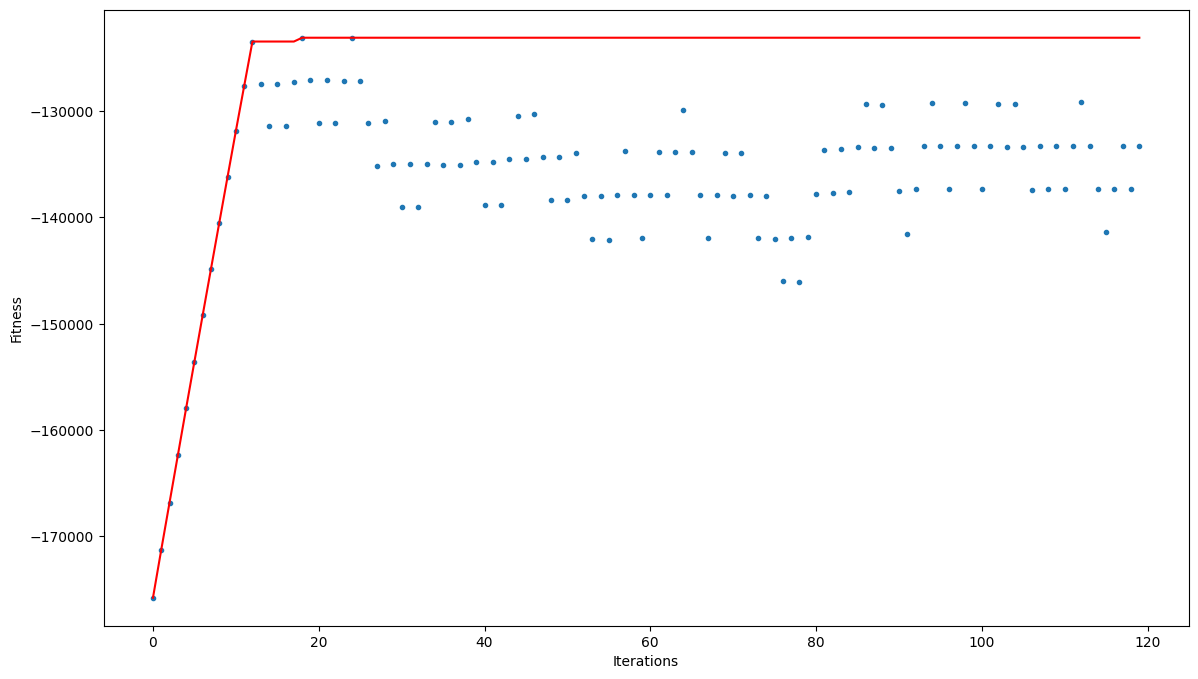

In [48]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(history)), list(accumulate(history, max)), color = "red")
_ = plt.scatter(range(len(history)), history, marker=".")
plt.xlabel("Iterations")
plt.ylabel("Fitness")